# Setup and data ingestion

In [4]:
library(conflicted)
library(IRdisplay)
library(xtable)
conflict_prefer("display", "IRdisplay")

# Stats
library(car)

# Data manipulation
library(tidyverse)
conflict_prefer("filter", "dplyr")
library(reshape2)

# Data loading
library(jsonlite)
library(writexl)
library(readxl)

[conflicted] Removing existing preference
[conflicted] Will prefer IRdisplay::display over any other package
[conflicted] Removing existing preference
[conflicted] Will prefer dplyr::filter over any other package


In [5]:
# Workbook settings
options(repr.matrix.max.rows=250, repr.matrix.max.cols=30)

Set options for analysis

In [55]:
get_rel_file <- function(file) {
    return(file.path("output", "2018-12-07_2019-03-19", file))
}

First we need to import the data and tidy up the datatypes a bit

In [56]:
datafile <- bzfile(get_rel_file("out2.json.bz2"), open='r')
data <- stream_in(datafile, flatten=TRUE)
close(datafile)

 Imported 29863 records. Simplifying...


Now we split off just the ads from our data

In [57]:
ads <- data %>% filter(type == 'ad')

nrow(ads)

[1] 26870

In [58]:
ads$ranking <- NULL

ads$treatment.ethnicity <- as.factor(ads$treatment.ethnicity)
ads$treatment.gender <- as.factor(ads$treatment.gender)
ads$type <- as.factor(ads$type)
ads$scraper <- as.factor(ads$scraper)
ads$block_id <- as.factor(ads$block_id)
ads$agent_id <- as.factor(ads$agent_id)
data$time <- as.POSIXct(data$time)

Next we write out the data for coding

In [59]:
unique_ads <- unique(ads[c("ad.title", "ad.url", "ad.image_path")])
write_xlsx(unique_ads, get_rel_file("unique-ads.xlsx"))
nrow(unique_ads)

[1] 3275

Now code the results, read them back in, and join them to the existing data

In [60]:
categorized_ads <- read_excel(get_rel_file("unique-ads-coded.xlsx"))
categorized_ads$ad.category <- as.factor(categorized_ads$category)
categorized_ads$category <- NULL
categorized_ads$ad.title <- gsub("\r\n", "\n", categorized_ads$ad.title)

In [61]:
levels(categorized_ads$ad.category)

[1] "aggregator"    "bank"          "clothing"      "credit card"  
 [5] "foreclosure"   "investment"    "listing"       "loan"         
 [9] "mobile homes"  "political"     "realtor"       "rental"       
[13] "rental group"  "rent-to-own"   "search engine" "senior"       
[17] "x"

In [63]:
merged <- ads %>%
  inner_join(categorized_ads, by = c("ad.url", "ad.image_path", "ad.title"))

nrow(ads)
nrow(merged)

include_control <- TRUE
# include_control <- FALSE

merged <- merged %>% filter(include_control | (treatment.ethnicity != "Control" & treatment.gender != "Control"))
nrow(merged)

[1] 26870

[1] 26255

[1] 26255

In [64]:
# datafile <- bzfile(get_rel_file("coded-output.json.bz2"), open='w')
stream_out(merged, con=bzfile(get_rel_file("coded-output.json.bz2"), open='w'))

Complete! Processed total of 26255 rows.


In [14]:
agents <- unique(merged[c("agent_id", "treatment.ethnicity", "treatment.gender")])

agent_count <- agents %>%
  count(treatment.ethnicity, treatment.gender, name = "num_agents")

nrow(agents)

Warning message:
“Factor `treatment.ethnicity` contains implicit NA, consider using `forcats::fct_explicit_na`”Warning message:
“Factor `treatment.gender` contains implicit NA, consider using `forcats::fct_explicit_na`”

[1] 766

In [179]:
merged %>% 
  count(treatment.ethnicity, treatment.gender, name = "num_ads") %>%
  right_join(agent_count, by = c("treatment.ethnicity", "treatment.gender"))

# tmp
# tmp %>%
#   xtable() %>% 
#   print(include.rownames = FALSE)

treatment.ethnicity,treatment.gender,num_ads,num_agents
african-american,female,2540,94
african-american,male,2665,92
asian,female,2720,94
asian,male,2729,98
caucasian,female,2630,94
caucasian,male,2755,92
hispanic,female,2596,95
hispanic,male,2668,95
Control,Control,437,12


# Ad Analysis

## Overall ads

In [194]:
overall_ads <- merged %>%
  filter(ad.category == 'aggregator' | ad.category == 'foreclosure' | ad.category == 'listing' | ad.category == 'loan' | ad.category == 'mobile homes' | ad.category == 'realtor' | ad.category == 'rental' | ad.category == 'rental group' | ad.category == 'rent-to-own')

nrow(overall_ads)

# overall_ads %>%
#   count(treatment.ethnicity, treatment.gender, agent_id, name = "num_ads") %>%
# #   right_join(agent_count, by = c("treatment.ethnicity", "treatment.gender")) %>%
#   group_by(treatment.ethnicity, treatment.gender) %>%
#   summarize(avg=mean(num_ads), sd=sd(num_ads), med=median(num_ads))

# overall_ads %>%
#   count(treatment.ethnicity, treatment.gender, name = "num_ads") %>%
#   right_join(agent_count, by = c("treatment.ethnicity", "treatment.gender")) %>%
#   mutate(avg=num_ads/num_agents)

overall_count <- overall_ads %>%
  count(agent_id, treatment.ethnicity, treatment.gender, scraper) %>%
  right_join(agents, by = c("agent_id", "treatment.ethnicity", "treatment.gender")) %>%
  mutate(n=replace_na(n, 0), scraper=replace_na(scraper, 'GoogleSearchAdScraper')) %>%
  complete(nesting(agent_id, treatment.ethnicity, treatment.gender), scraper, fill = list(n = 0))

[1] 12418

In [205]:
# overall_count
overall_count %>%
  group_by(treatment.ethnicity, treatment.gender, agent_id) %>%
  summarize(n=sum(n)) %>%
  group_by(treatment.ethnicity, treatment.gender) %>%
  summarize(avg=mean(n), sd=sd(n), med=median(n))

treatment.ethnicity,treatment.gender,avg,sd,med
african-american,female,15.17021,10.840623,15
african-american,male,16.73913,12.817287,15
asian,female,16.38298,11.283356,15
asian,male,16.13265,10.787199,14
caucasian,female,16.14894,12.714362,13
caucasian,male,17.96739,11.883548,17
hispanic,female,15.65263,10.117153,15
hispanic,male,15.91579,10.440982,15
Control,Control,13.41667,8.414904,11


In [181]:
overall_ads %>%
   filter(treatment.ethnicity == 'Control') %>%
   filter(scraper != 'GoogleSearchAdScraper') %>%
   count()

n
77


### All scrapers

In [129]:
local_data <- overall_count

res.overall <- aov(n ~ treatment.ethnicity * treatment.gender, data = local_data)
summary(res.overall)

# plot(res.overall, 1)
fligner.test(n ~ interaction(treatment.ethnicity, treatment.gender), data = local_data)
# plot(res.overall, 2)
# shapiro.test(residuals(res.overall))

                                       Df Sum Sq Mean Sq F value Pr(>F)
treatment.ethnicity                     3     59   19.66   0.228  0.877
treatment.gender                        1     44   44.14   0.513  0.474
treatment.ethnicity:treatment.gender    3     47   15.78   0.183  0.908
Residuals                            2254 193996   86.07               


	Fligner-Killeen test of homogeneity of variances

data:  n by interaction(treatment.ethnicity, treatment.gender)
Fligner-Killeen:med chi-squared = 33.097, df = 7, p-value = 2.54e-05


### BBC Scraper

                                      Df Sum Sq Mean Sq F value Pr(>F)
treatment.ethnicity                    3    2.1  0.7013   1.537  0.204
treatment.gender                       1    0.7  0.7115   1.559  0.212
treatment.ethnicity:treatment.gender   3    0.8  0.2762   0.605  0.612
Residuals                            746  340.4  0.4563               


	Fligner-Killeen test of homogeneity of variances

data:  n by interaction(treatment.ethnicity, treatment.gender)
Fligner-Killeen:med chi-squared = 6.6432, df = 7, p-value = 0.4669


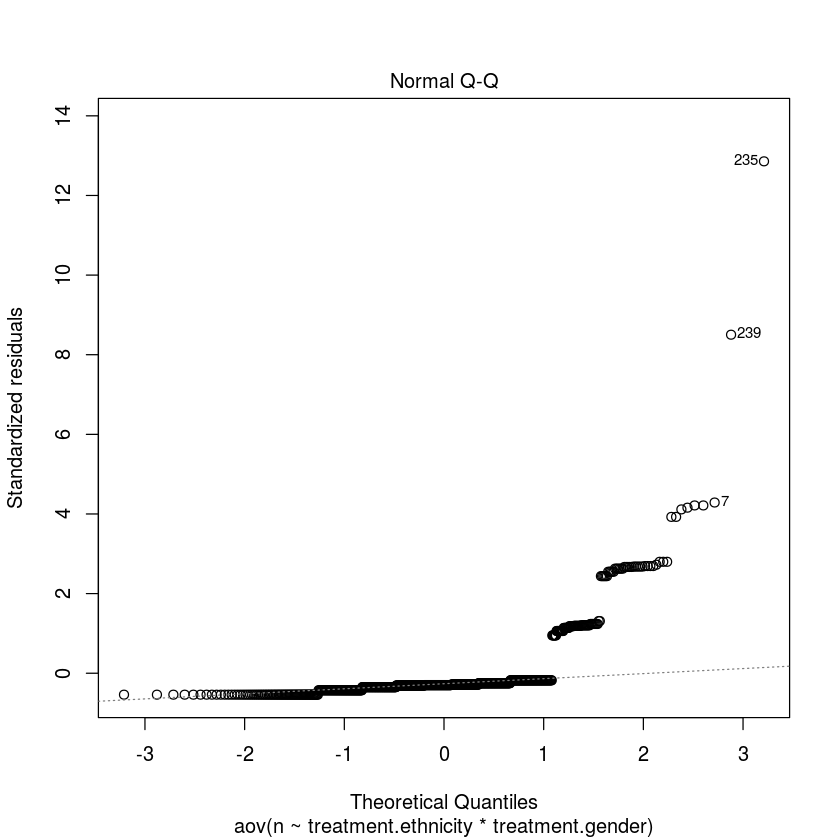

In [130]:
local_data <- filter(overall_count, scraper == 'BBCAdScraper')

res.overall <- aov(n ~ treatment.ethnicity * treatment.gender, data = local_data)
summary(res.overall)

# plot(res.overall, 1)
fligner.test(n ~ interaction(treatment.ethnicity, treatment.gender), data = local_data)
plot(res.overall, 2)
# shapiro.test(residuals(res.overall))

### Google Scraper

                                      Df Sum Sq Mean Sq F value Pr(>F)
treatment.ethnicity                    3    255   85.08   0.758  0.518
treatment.gender                       1    172  172.28   1.536  0.216
treatment.ethnicity:treatment.gender   3    149   49.62   0.442  0.723
Residuals                            746  83697  112.19               


	Fligner-Killeen test of homogeneity of variances

data:  n by interaction(treatment.ethnicity, treatment.gender)
Fligner-Killeen:med chi-squared = 10.037, df = 7, p-value = 0.1865


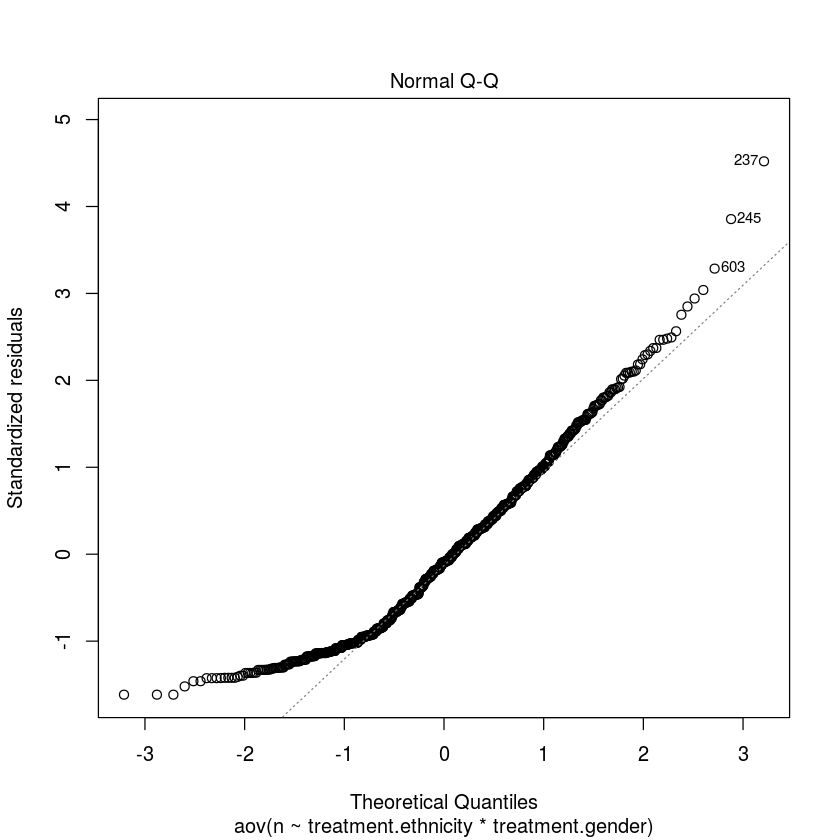

In [131]:
local_data <- filter(overall_count, scraper == 'GoogleSearchAdScraper')

res.overall <- aov(n ~ treatment.ethnicity * treatment.gender, data = local_data)
summary(res.overall)

# plot(res.overall, 1)
fligner.test(n ~ interaction(treatment.ethnicity, treatment.gender), data = local_data)
plot(res.overall, 2)
# shapiro.test(residuals(res.overall))

### News Gazette Scraper

                                      Df Sum Sq Mean Sq F value Pr(>F)
treatment.ethnicity                    3      4   1.247   0.177  0.912
treatment.gender                       1      1   0.600   0.085  0.770
treatment.ethnicity:treatment.gender   3      2   0.728   0.104  0.958
Residuals                            746   5250   7.038               


	Fligner-Killeen test of homogeneity of variances

data:  n by interaction(treatment.ethnicity, treatment.gender)
Fligner-Killeen:med chi-squared = 1.7607, df = 7, p-value = 0.9719


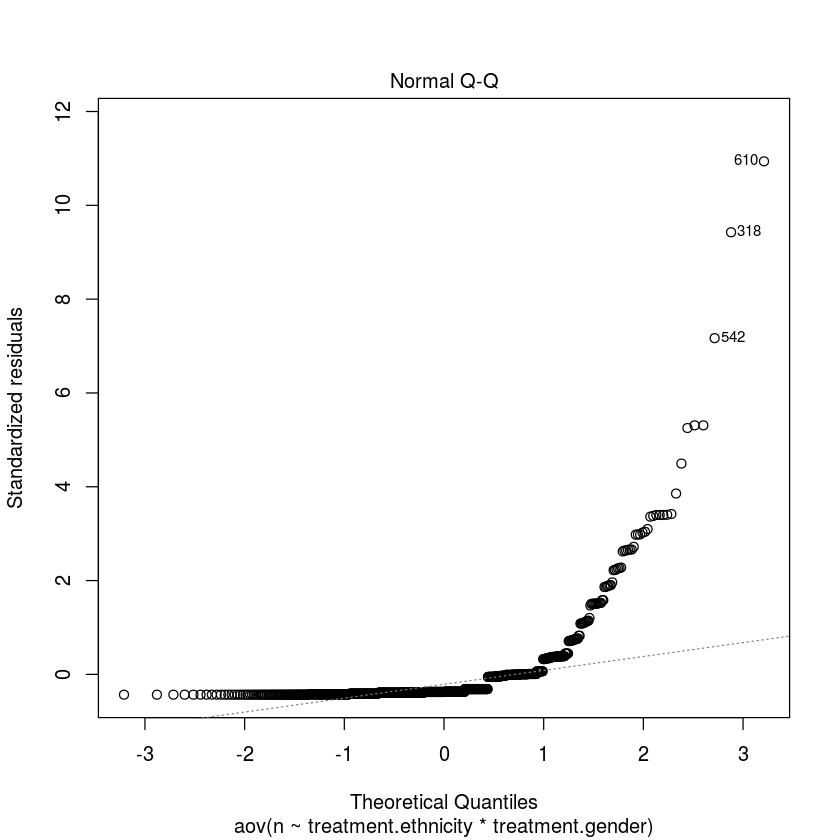

In [132]:
local_data <- filter(overall_count, scraper == 'NewsGazetteAdScraper')

res.overall <- aov(n ~ treatment.ethnicity * treatment.gender, data = local_data)
summary(res.overall)

# plot(res.overall, 1)
fligner.test(n ~ interaction(treatment.ethnicity, treatment.gender), data = local_data)
plot(res.overall, 2)
# shapiro.test(residuals(res.overall))

## Listing Ads

In [140]:
listings <- merged %>%
  filter(ad.category == 'listing' | ad.category == 'rental' | ad.category == 'mobile homes')

nrow(listings)

listings %>%
  count(treatment.ethnicity, treatment.gender, name = "num_ads") %>%
  right_join(agent_count, by = c("treatment.ethnicity", "treatment.gender")) %>%
  mutate(avg=num_ads/num_agents)

listings %>% count(scraper)

listings_count <- listings %>%
  count(agent_id, treatment.ethnicity, treatment.gender, scraper)
#   count(agent_id, treatment.ethnicity, treatment.gender, scraper) %>%
#   right_join(agents, by = c("agent_id", "treatment.ethnicity", "treatment.gender")) %>%
#   mutate(n=replace_na(n, 0), scraper=replace_na(scraper, 'GoogleSearchAdScraper')) %>%
#   complete(nesting(agent_id, treatment.ethnicity, treatment.gender), scraper, fill = list(n = 0))

[1] 444

treatment.ethnicity,treatment.gender,num_ads,num_agents,avg
african-american,female,58,94,0.6170213
african-american,male,57,92,0.6195652
asian,female,55,94,0.5851064
asian,male,50,98,0.5102041
caucasian,female,50,94,0.5319149
caucasian,male,60,92,0.6521739
hispanic,female,53,95,0.5578947
hispanic,male,61,95,0.6421053


scraper,n
GoogleSearchAdScraper,385
NewsGazetteAdScraper,59


                                      Df Sum Sq Mean Sq F value Pr(>F)
treatment.ethnicity                    3    5.3  1.7644   0.795  0.498
treatment.gender                       1    0.8  0.7528   0.339  0.561
treatment.ethnicity:treatment.gender   3    0.7  0.2378   0.107  0.956
Residuals                            193  428.5  2.2200               


	Fligner-Killeen test of homogeneity of variances

data:  n by interaction(treatment.ethnicity, treatment.gender)
Fligner-Killeen:med chi-squared = 2.2774, df = 7, p-value = 0.9429


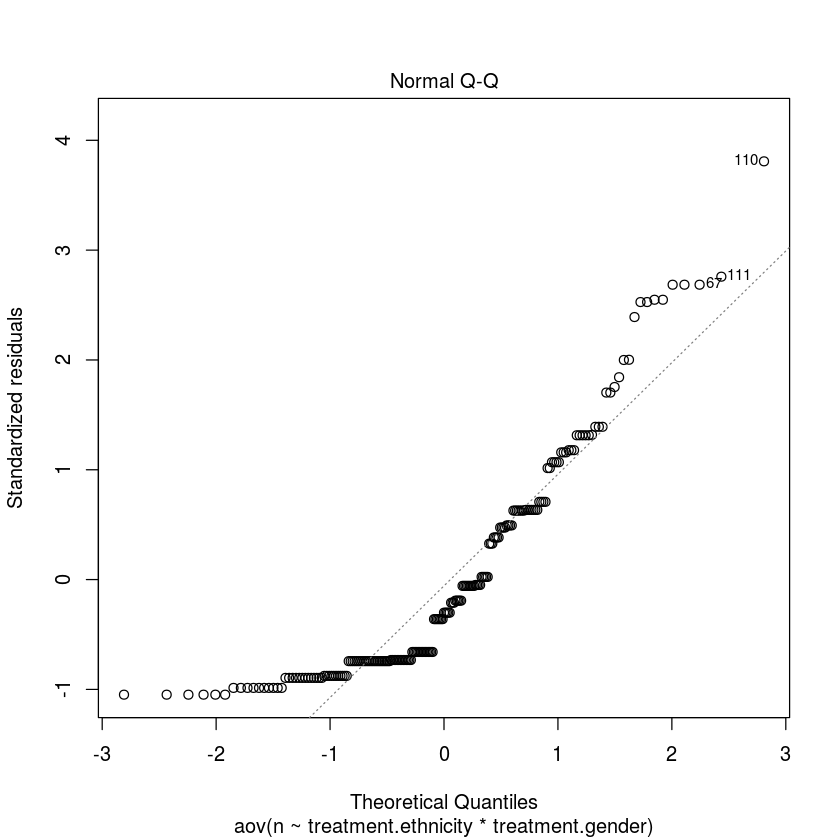

In [141]:
res.listings <- aov(n ~ treatment.ethnicity * treatment.gender, data = listings_count)
summary(res.listings)

# plot(res.listings, 1)
fligner.test(n ~ interaction(treatment.ethnicity, treatment.gender), data = listings_count)
plot(res.listings, 2)
# shapiro.test(x = residuals(object = res.listings))

                                      Df Sum Sq Mean Sq F value Pr(>F)
treatment.ethnicity                    3    9.4  3.1403   1.308  0.274
treatment.gender                       1    3.1  3.0824   1.284  0.259
treatment.ethnicity:treatment.gender   3    0.3  0.1001   0.042  0.989
Residuals                            150  360.1  2.4004               


	Fligner-Killeen test of homogeneity of variances

data:  n by interaction(treatment.ethnicity, treatment.gender)
Fligner-Killeen:med chi-squared = 2.2774, df = 7, p-value = 0.9429


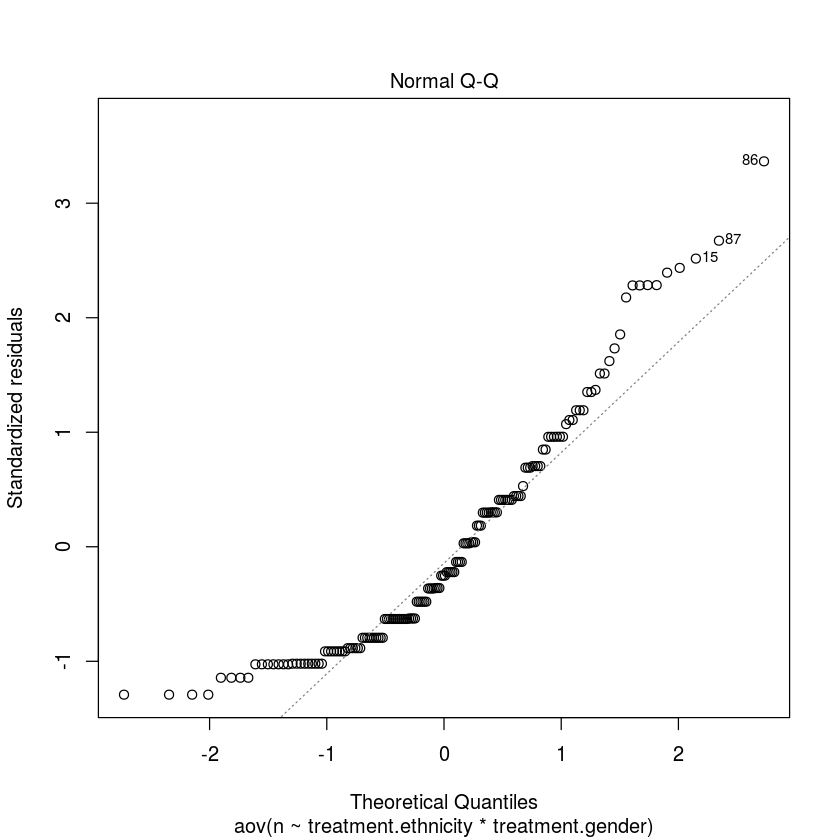

In [142]:
res.listings <- aov(n ~ treatment.ethnicity * treatment.gender, data = filter(listings_count, scraper == 'GoogleSearchAdScraper'))
summary(res.listings)

# plot(res.listings, 1)
fligner.test(n ~ interaction(treatment.ethnicity, treatment.gender), data = listings_count)
plot(res.listings, 2)
# shapiro.test(x = residuals(object = res.listings))

## Loan Ads

In [143]:
loan_ads <- merged %>%
  filter(ad.category == 'loan')

nrow(loan_ads)

loan_ads %>%
  count(treatment.ethnicity, treatment.gender, name = "num_ads") %>%
  right_join(agent_count, by = c("treatment.ethnicity", "treatment.gender")) %>%
  mutate(avg=num_ads/num_agents)

loan_ads %>% count(scraper)

loan_ads_count <- loan_ads %>%
  count(agent_id, treatment.ethnicity, treatment.gender, scraper)
#   count(agent_id, treatment.ethnicity, treatment.gender, scraper) %>%
#   inner_join(agents, by = c("agent_id", "treatment.ethnicity", "treatment.gender")) %>%
#   mutate(n=replace_na(n, 0), scraper=replace_na(scraper, 'GoogleSearchAdScraper')) %>%
#   complete(nesting(agent_id, treatment.ethnicity, treatment.gender), scraper, fill = list(n = 0))

[1] 414

treatment.ethnicity,treatment.gender,num_ads,num_agents,avg
african-american,female,69,94,0.7340426
african-american,male,48,92,0.5217391
asian,female,58,94,0.6170213
asian,male,48,98,0.4897959
caucasian,female,51,94,0.5425532
caucasian,male,38,92,0.4130435
hispanic,female,49,95,0.5157895
hispanic,male,53,95,0.5578947


scraper,n
BBCAdScraper,163
NewsGazetteAdScraper,251


                                      Df Sum Sq Mean Sq F value Pr(>F)
treatment.ethnicity                    3   1.23  0.4112   0.648  0.585
treatment.gender                       1   0.15  0.1531   0.241  0.624
treatment.ethnicity:treatment.gender   3   0.90  0.3016   0.476  0.700
Residuals                            285 180.74  0.6342               


	Fligner-Killeen test of homogeneity of variances

data:  n by interaction(treatment.ethnicity, treatment.gender)
Fligner-Killeen:med chi-squared = 3.3126, df = 7, p-value = 0.8547


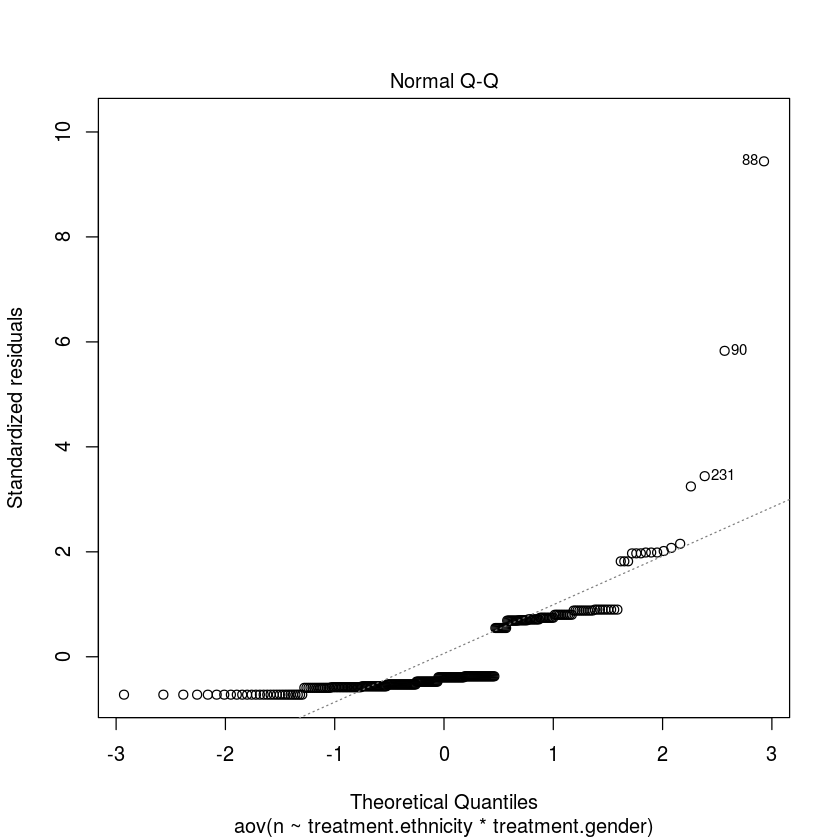

In [144]:
local_data <- loan_ads_count

res.local <- aov(n ~ treatment.ethnicity * treatment.gender, data = local_data)
summary(res.local)
# summary(res.local) %>% xtable() %>% print()

# plot(res.local, 1)
fligner.test(n ~ interaction(treatment.ethnicity, treatment.gender), data = local_data)
plot(res.local, 2)
# shapiro.test(x = residuals(res.local))

                                     Df Sum Sq Mean Sq F value Pr(>F)
treatment.ethnicity                   3   3.16  1.0544   0.940  0.424
treatment.gender                      1   0.21  0.2132   0.190  0.664
treatment.ethnicity:treatment.gender  3   2.48  0.8258   0.736  0.533
Residuals                            96 107.67  1.1216               


	Fligner-Killeen test of homogeneity of variances

data:  n by interaction(treatment.ethnicity, treatment.gender)
Fligner-Killeen:med chi-squared = 6.5856, df = 7, p-value = 0.4733


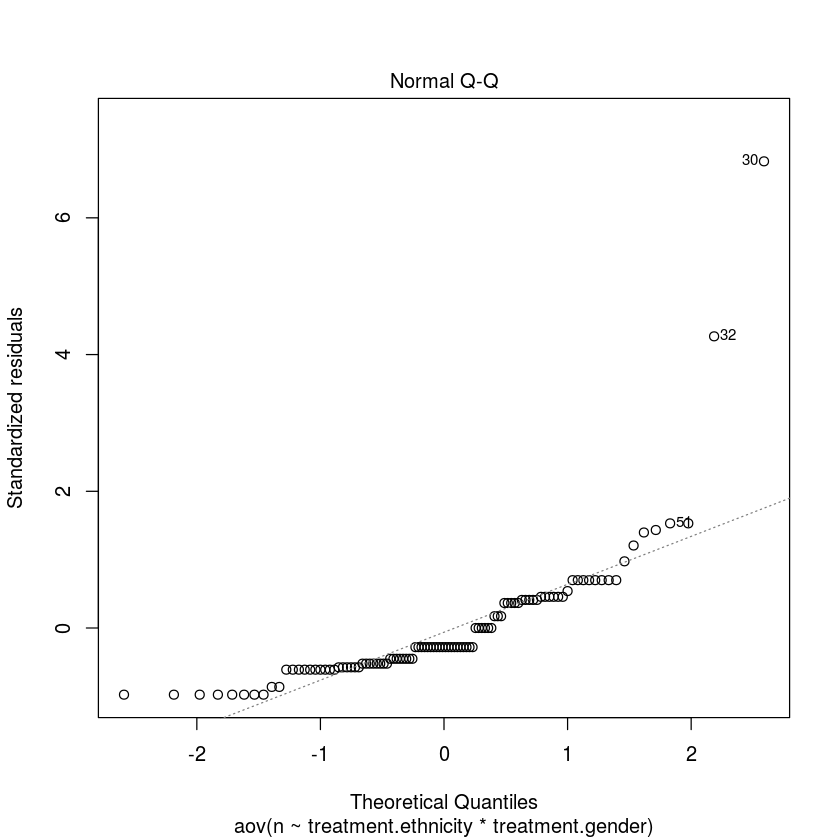

In [145]:
local_data <- filter(loan_ads_count, scraper == 'BBCAdScraper')

res.local <- aov(n ~ treatment.ethnicity * treatment.gender, data = local_data)
summary(res.local)
# summary(res.local) %>% xtable() %>% print()

# plot(res.local, 1)
fligner.test(n ~ interaction(treatment.ethnicity, treatment.gender), data = local_data)
plot(res.local, 2)
# shapiro.test(x = residuals(res.local))

                                      Df Sum Sq Mean Sq F value Pr(>F)
treatment.ethnicity                    3   0.24  0.0798   0.222  0.881
treatment.gender                       1   0.02  0.0217   0.060  0.806
treatment.ethnicity:treatment.gender   3   0.28  0.0930   0.259  0.855
Residuals                            181  65.12  0.3598               


	Fligner-Killeen test of homogeneity of variances

data:  n by interaction(treatment.ethnicity, treatment.gender)
Fligner-Killeen:med chi-squared = 1.7003, df = 7, p-value = 0.9746


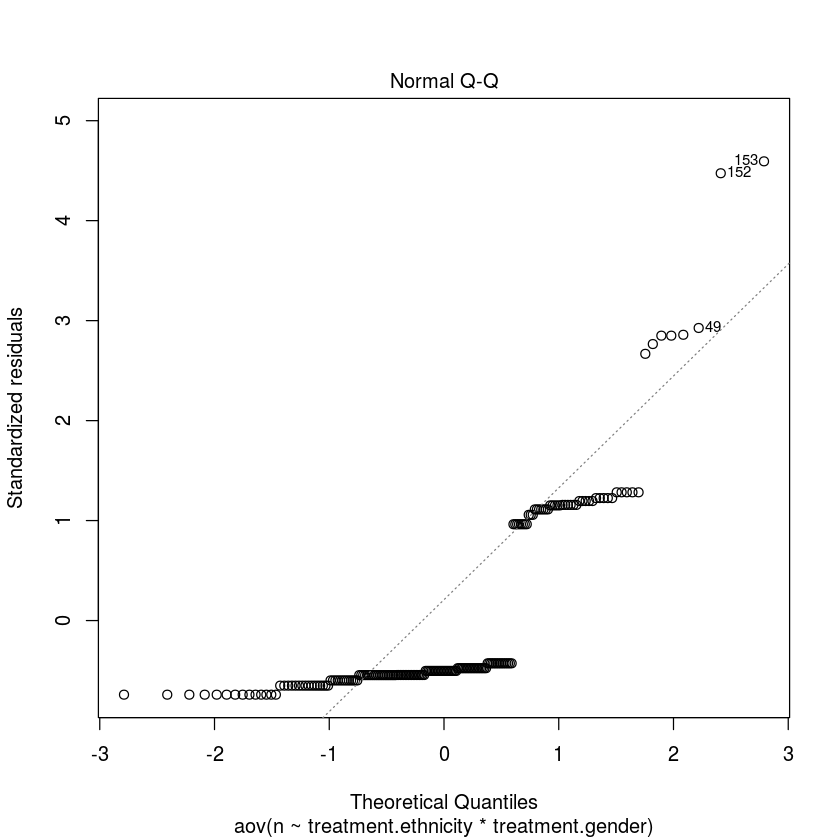

In [146]:
local_data <- filter(loan_ads_count, scraper == 'NewsGazetteAdScraper')

res.local <- aov(n ~ treatment.ethnicity * treatment.gender, data = local_data)
summary(res.local)
# summary(res.local) %>% xtable() %>% print()

# plot(res.local, 1)
fligner.test(n ~ interaction(treatment.ethnicity, treatment.gender), data = local_data)
plot(res.local, 2)
# shapiro.test(x = residuals(res.local))

## Rent-to-own and Foreclosures

In [138]:
data <- merged %>%
  filter(ad.category == 'rent-to-own' | ad.category == 'search engine')

nrow(data)

# data %>%
#   count(treatment.ethnicity, treatment.gender, name = "num_ads") %>%
#   right_join(agent_count, by = c("treatment.ethnicity", "treatment.gender")) %>%
#   mutate(avg=num_ads/num_agents)

data_count <- data %>%
  count(agent_id, treatment.ethnicity, treatment.gender, scraper)
#   count(agent_id, treatment.ethnicity, treatment.gender, scraper) %>%
#   right_join(agents, by = c("agent_id", "treatment.ethnicity", "treatment.gender")) %>%
#   mutate(n=replace_na(n, 0), scraper=replace_na(scraper, 'GoogleSearchAdScraper')) %>%
#   complete(nesting(agent_id, treatment.ethnicity, treatment.gender), scraper, fill = list(n = 0))

[1] 45

                                     Df Sum Sq Mean Sq F value Pr(>F)
treatment.ethnicity                   2  25.20  12.600   2.404  0.146
treatment.gender                      1   0.11   0.112   0.021  0.887
treatment.ethnicity:treatment.gender  2   3.52   1.760   0.336  0.723
Residuals                             9  47.17   5.241               


	Fligner-Killeen test of homogeneity of variances

data:  n by interaction(treatment.ethnicity, treatment.gender)
Fligner-Killeen:med chi-squared = 9.1439, df = 5, p-value = 0.1035


Warning message:
“not plotting observations with leverage one:
  2”

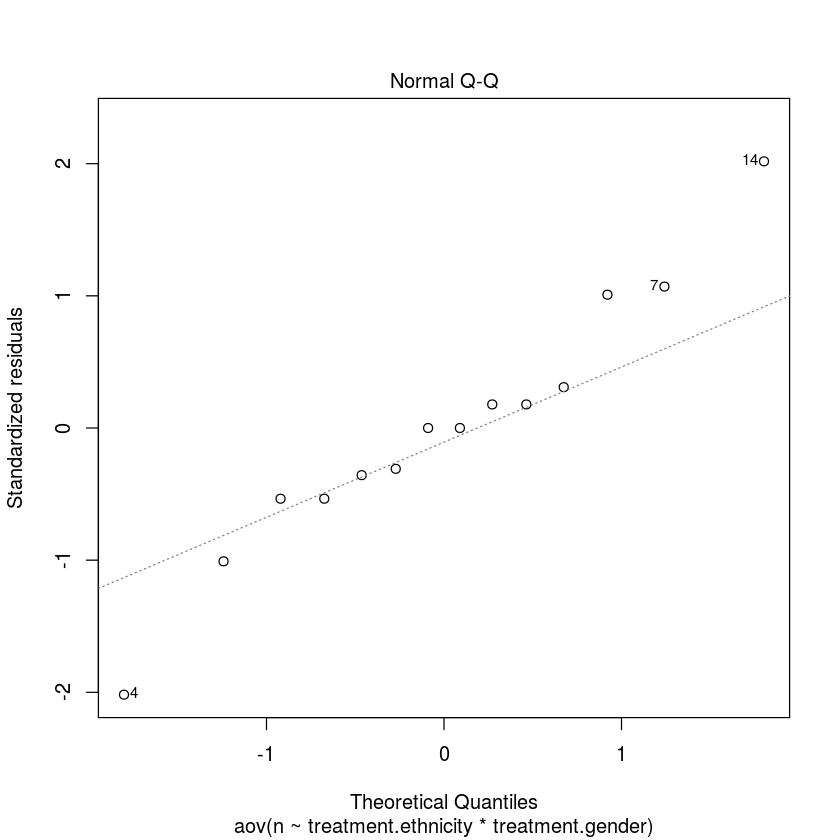

In [121]:
local_data <- data_count

res.local <- aov(n ~ treatment.ethnicity * treatment.gender, data = local_data)
summary(res.local)
# summary(res.local) %>% xtable() %>% print()

# plot(res.local, 1)
fligner.test(n ~ interaction(treatment.ethnicity, treatment.gender), data = local_data)
plot(res.local, 2)
# shapiro.test(x = residuals(res.local))

## Pairwise Tests

### Overall Ads

In [72]:
overall_ads <- merged %>%
  filter(ad.category == 'aggregator' | ad.category == 'foreclosure' | ad.category == 'listing' | ad.category == 'loan' | ad.category == 'mobile homes' | ad.category == 'realtor' | ad.category == 'rental' | ad.category == 'rental group' | ad.category == 'rent-to-own')

# overall_count <- overall_ads %>%
#   count(agent_id, treatment.ethnicity, treatment.gender, scraper) %>%
#   right_join(agents, by = c("agent_id", "treatment.ethnicity", "treatment.gender")) %>%
#   mutate(n=replace_na(n, 0), scraper=replace_na(scraper, 'GoogleSearchAdScraper')) %>%
#   complete(nesting(agent_id, treatment.ethnicity, treatment.gender), scraper, fill = list(n = 0))

In [148]:
pairwise_ads <- overall_ads

for (value in levels(pairwise_ads$treatment.ethnicity)) {
    cat("Ethnicity: ", value, "\n")
    pairwise <- pairwise_ads
    pairwise$treatment.ethnicity <- pairwise$treatment.ethnicity == value
    print(summary(aov(n ~ treatment.ethnicity * treatment.gender, data = count(pairwise, agent_id, treatment.ethnicity, treatment.gender, scraper))))
    cat("\n")
}

Ethnicity:  african-american 
                                       Df Sum Sq Mean Sq F value Pr(>F)
treatment.ethnicity                     1     26   26.19   0.232  0.630
treatment.gender                        1    254  254.43   2.258  0.133
treatment.ethnicity:treatment.gender    1     66   65.84   0.584  0.445
Residuals                            1085 122261  112.68               

Ethnicity:  asian 
                                       Df Sum Sq Mean Sq F value Pr(>F)
treatment.ethnicity                     1     27   27.15   0.241  0.624
treatment.gender                        1    259  259.39   2.302  0.129
treatment.ethnicity:treatment.gender    1     68   68.17   0.605  0.437
Residuals                            1085 122252  112.67               

Ethnicity:  caucasian 
                                       Df Sum Sq Mean Sq F value Pr(>F)  
treatment.ethnicity                     1    362   362.5   3.230 0.0726 .
treatment.gender                        1    272   272.5  

### Direct Listings

In [149]:
pairwise_ads <- merged %>%
  filter(ad.category == 'listing' | ad.category == 'rental' | ad.category == 'mobile homes')

for (value in levels(pairwise_ads$treatment.ethnicity)) {
    cat("Ethnicity: ", value, "\n")
    pairwise <- pairwise_ads
    pairwise$treatment.ethnicity <- pairwise$treatment.ethnicity == value
    print(summary(aov(n ~ treatment.ethnicity * treatment.gender, data = count(pairwise, agent_id, treatment.ethnicity, treatment.gender, scraper))))
    cat("\n")
}

Ethnicity:  african-american 
                                      Df Sum Sq Mean Sq F value Pr(>F)
treatment.ethnicity                    1    0.1  0.1103   0.050  0.823
treatment.gender                       1    1.0  0.9850   0.447  0.505
treatment.ethnicity:treatment.gender   1    0.1  0.0841   0.038  0.845
Residuals                            197  434.0  2.2033               

Ethnicity:  asian 
                                      Df Sum Sq Mean Sq F value Pr(>F)
treatment.ethnicity                    1    2.5  2.5250   1.152  0.284
treatment.gender                       1    0.9  0.8752   0.399  0.528
treatment.ethnicity:treatment.gender   1    0.0  0.0030   0.001  0.971
Residuals                            197  431.8  2.1920               

Ethnicity:  caucasian 
                                      Df Sum Sq Mean Sq F value Pr(>F)
treatment.ethnicity                    1    0.0  0.0053   0.002  0.961
treatment.gender                       1    1.0  1.0089   0.458  0.499
tre

### Searches

In [150]:
pairwise_ads <- merged %>%
  filter(ad.category == 'aggregator' | ad.category == 'foreclosure' | ad.category == 'realtor' | ad.category == 'rental group' | ad.category == 'rent-to-own')
#   count(agent_id, treatment.ethnicity, treatment.gender, scraper)

for (value in levels(pairwise_ads$treatment.ethnicity)) {
    cat("Ethnicity: ", value, "\n")
    pairwise <- pairwise_ads
    pairwise$treatment.ethnicity <- pairwise$treatment.ethnicity == value
    print(summary(aov(n ~ treatment.ethnicity * treatment.gender, data = count(pairwise, agent_id, treatment.ethnicity, treatment.gender, scraper))))
    cat("\n")
}

Ethnicity:  african-american 
                                      Df Sum Sq Mean Sq F value Pr(>F)
treatment.ethnicity                    1      0    0.09   0.001  0.977
treatment.gender                       1    152  152.50   1.427  0.233
treatment.ethnicity:treatment.gender   1    116  115.71   1.082  0.298
Residuals                            831  88833  106.90               

Ethnicity:  asian 
                                      Df Sum Sq Mean Sq F value Pr(>F)
treatment.ethnicity                    1     17   17.08   0.160  0.689
treatment.gender                       1    154  154.43   1.445  0.230
treatment.ethnicity:treatment.gender   1    107  107.12   1.002  0.317
Residuals                            831  88823  106.89               

Ethnicity:  caucasian 
                                      Df Sum Sq Mean Sq F value Pr(>F)
treatment.ethnicity                    1    194  194.49   1.821  0.178
treatment.gender                       1    151  151.15   1.415  0.235
tre

In [151]:
pairwise_ads <- merged %>%
  filter(ad.category == 'aggregator' | ad.category == 'foreclosure' | ad.category == 'realtor' | ad.category == 'rental group' | ad.category == 'rent-to-own')

for (value in levels(pairwise_ads$treatment.ethnicity)) {
    cat("Ethnicity: ", value, "\n")
    pairwise <- pairwise_ads
    pairwise$treatment.ethnicity <- pairwise$treatment.ethnicity == value
    print(summary(aov(n ~ treatment.ethnicity * treatment.gender, data = count(pairwise, agent_id, treatment.ethnicity, treatment.gender, scraper))))
    cat("\n")
}

Ethnicity:  african-american 
                                      Df Sum Sq Mean Sq F value Pr(>F)
treatment.ethnicity                    1      0    0.09   0.001  0.977
treatment.gender                       1    152  152.50   1.427  0.233
treatment.ethnicity:treatment.gender   1    116  115.71   1.082  0.298
Residuals                            831  88833  106.90               

Ethnicity:  asian 
                                      Df Sum Sq Mean Sq F value Pr(>F)
treatment.ethnicity                    1     17   17.08   0.160  0.689
treatment.gender                       1    154  154.43   1.445  0.230
treatment.ethnicity:treatment.gender   1    107  107.12   1.002  0.317
Residuals                            831  88823  106.89               

Ethnicity:  caucasian 
                                      Df Sum Sq Mean Sq F value Pr(>F)
treatment.ethnicity                    1    194  194.49   1.821  0.178
treatment.gender                       1    151  151.15   1.415  0.235
tre

### Rent-to-own and Foreclosures

In [164]:
pairwise_ads <- merged %>%
  filter(treatment.ethnicity != 'Control' & treatment.gender != 'Control') %>%
  filter(ad.category == 'rent-to-own' | ad.category == 'foreclosure' | ad.category == 'search engine')

pairwise_ads %>%
  count(treatment.ethnicity, treatment.gender, name = "num_ads") %>%
  right_join(agent_count, by = c("treatment.ethnicity", "treatment.gender")) %>%
  mutate(avg=num_ads/num_agents)

for (value in levels(pairwise_ads$treatment.ethnicity)) {
    cat("Ethnicity: ", value, "\n")
    pairwise <- pairwise_ads
    pairwise$treatment.ethnicity <- pairwise$treatment.ethnicity == value
    print(summary(aov(n ~ treatment.ethnicity * treatment.gender, data = count(pairwise, agent_id, treatment.ethnicity, treatment.gender, scraper))))
#     aov(n ~ treatment.ethnicity * treatment.gender, data = count(pairwise, agent_id, treatment.ethnicity, treatment.gender, scraper)) %>% xtable() %>% print()
    cat("\n")
}

treatment.ethnicity,treatment.gender,num_ads,num_agents,avg
african-american,female,50,94,0.5319149
african-american,male,70,92,0.7608696
asian,female,53,94,0.5638298
asian,male,50,98,0.5102041
caucasian,female,50,94,0.5319149
caucasian,male,33,92,0.3586957
hispanic,female,60,95,0.6315789
hispanic,male,48,95,0.5052632


Ethnicity:  african-american 
                                     Df Sum Sq Mean Sq F value  Pr(>F)   
treatment.ethnicity                   1   40.1   40.12   2.430 0.12260   
treatment.gender                      1    4.7    4.72   0.286 0.59402   
treatment.ethnicity:treatment.gender  1  125.3  125.30   7.590 0.00713 **
Residuals                            88 1452.9   16.51                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Ethnicity:  asian 
                                     Df Sum Sq Mean Sq F value Pr(>F)
treatment.ethnicity                   1    1.4   1.409   0.077  0.782
treatment.gender                      1    2.6   2.607   0.142  0.707
treatment.ethnicity:treatment.gender  1    2.8   2.809   0.153  0.697
Residuals                            88 1616.2  18.366               

Ethnicity:  caucasian 
                                     Df Sum Sq Mean Sq F value Pr(>F)
treatment.ethnicity                   1   15.3  15.294   0.844  0.361

# Test Area

In [ ]:
merged %>%
  filter(ad.cate)

# Profile Validation

In [54]:
clothing_ads <- merged %>%
  filter(ad.category == 'clothing') %>%
  count(treatment.ethnicity, treatment.gender, agent_id, gender) %>%
  right_join(agents, by = c("agent_id", "treatment.ethnicity", "treatment.gender")) %>%
  complete(nesting(agent_id, treatment.ethnicity, treatment.gender), gender, fill = list(n = 0)) %>%
  filter(!is.na(gender))

clothing_ads$gender <- as.factor(clothing_ads$gender)

# levels(clothing_ads$gender)

# min(clothing_ads$n)
# clothing_ads[1:10,]
# sum(clothing_ads$n)

# res.clothing <- aov(n ~ gender * treatment.gender * treatment.ethnicity, data = clothing_ads)
# summary(res.clothing)



Warning message:
“Factor `treatment.ethnicity` contains implicit NA, consider using `forcats::fct_explicit_na`”Warning message:
“Factor `treatment.gender` contains implicit NA, consider using `forcats::fct_explicit_na`”

[1] 167

n
21740


In [48]:
# clothing_ads
test <- clothing_ads %>% filter(gender == 'female')

t.test(filter(test, treatment.gender == 'male')$n, filter(test, treatment.gender == 'female')$n, paired=TRUE)


	Paired t-test

data:  filter(test, treatment.gender == "male")$n and filter(test, treatment.gender == "female")$n
t = -1.8534, df = 376, p-value = 0.06461
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.12573337  0.00371745
sample estimates:
mean of the differences 
            -0.06100796 
